# Model 1: Multivariate-3-RNN

## RNN

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

2025-06-01 14:04:00.047567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748786640.421214      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748786640.537456      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Cấu hình Seed để đảm bảo tính tái lập trong mô hình LSTM**  

1️⃣ `np.random.seed(1)`  
✅ Đặt **seed** cho NumPy.  
✅ Ảnh hưởng đến tất cả các hàm tạo số ngẫu nhiên của NumPy như:  
   - `np.random.rand()`  
   - `np.random.randn()`  
   - `np.random.randint()`  
   - ...  

2️⃣ `rn.seed(3)`  
✅ Đặt **seed** cho thư viện `random` của Python.  
✅ Ảnh hưởng đến các hàm như:  
   - `random.random()`  
   - `random.randint()`  
   - `random.choice()`  
   - ...  

3️⃣ `tf.random.set_seed(2)`  
✅ Đặt **seed** cho TensorFlow.  
✅ Ảnh hưởng đến:  
   - Việc khởi tạo trọng số ngẫu nhiên của mô hình **TensorFlow/Keras**, ví dụ:  
     - `tf.keras.layers.Dense`  
     - `tf.keras.layers.LSTM`  
   - Các phép toán sử dụng số ngẫu nhiên trong TensorFlow như:  
     - `tf.random.uniform()`  
     - `tf.random.normal()`  
     - ...  

📌 **Ghi chú:**  
- Việc đặt **seed** giúp đảm bảo **tính tái lập** trong các lần chạy mô hình.  
- Điều này giúp so sánh kết quả giữa các lần thử nghiệm một cách chính xác hơn.  


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras import optimizers

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [5]:
plt.style.use('ggplot')

### Hàm callback

In [6]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="best_model11.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"VN30 Index.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [8]:
print(df.head)

<bound method NDFrame.head of                open     high      low    close       volume
time                                                       
2009-01-05   311.23   311.23   311.23   311.23          NaN
2009-01-06   314.21   314.21   314.21   314.21          NaN
2009-01-07   320.53   320.53   320.53   320.53          NaN
2009-01-08   314.14   314.14   314.14   314.14          NaN
2009-01-09   312.90   312.90   312.90   312.90          NaN
...             ...      ...      ...      ...          ...
2025-03-14  1387.08  1394.39  1385.20  1387.03  374490000.0
2025-03-17  1392.75  1397.28  1389.42  1394.90  352180000.0
2025-03-18  1398.44  1400.38  1388.64  1388.64  291590000.0
2025-03-19  1385.92  1386.57  1374.83  1377.63  363360000.0
2025-03-20  1382.23  1388.37  1371.98  1378.95  359980000.0

[4044 rows x 5 columns]>


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
print(df.isnull().sum())

open        0
high        0
low         0
close       0
volume    859
dtype: int64


### Tiền xử lí dữ liệu

In [10]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [11]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999562
high      0.999783
low       0.999789
close     1.000000
volume    0.169492
Name: close, dtype: float64

**Phân tích tương quan giữa các biến trong dữ liệu chuỗi thời gian**  

🔹 `df.corr()`  
- Tính **ma trận tương quan** giữa tất cả các cột số trong DataFrame.  

🔹 `df.corr()['Close']`  
- Lấy **cột tương quan** giữa tất cả các biến với **giá đóng cửa** (`Close`).  
- Giúp xác định mức độ ảnh hưởng của các biến khác như:  
  - **Giá mở cửa** (`Open`)  
  - **Giá cao nhất** (`High`)  
  - **Giá thấp nhất** (`Low`)  
  - **Khối lượng giao dịch** (`Volume`)  

**Ý nghĩa của tương quan**  

- **Tương quan gần 1** → Biến có mối quan hệ **tỷ lệ thuận** mạnh với giá đóng cửa.  
- **Tương quan gần -1** → Biến có mối quan hệ **tỷ lệ nghịch** mạnh với giá đóng cửa.  
- **Tương quan gần 0** → Biến **ít hoặc không ảnh hưởng** đến giá đóng cửa.  

**Ứng dụng**  

- Chọn các biến có tương quan cao với `Close` để đưa vào mô hình dự đoán.  
- Loại bỏ các biến có tương quan thấp để tránh nhiễu dữ liệu.  


In [12]:
#  Tính toán các thống kê mô tả như trung bình (mean), độ lệch chuẩn (std), min, max, phần trăm phân vị (25%, 50%, 75%).
print(df.describe().volume) # Giúp kiểm tra phân bố của Volume, phát hiện các giá trị bất thường (outliers).

count    3.185000e+03
mean     3.279171e+06
std      2.776577e+07
min      4.540000e+03
25%      3.809000e+04
50%      6.036000e+04
75%      1.560100e+05
max      3.744900e+08
Name: volume, dtype: float64


<Axes: >

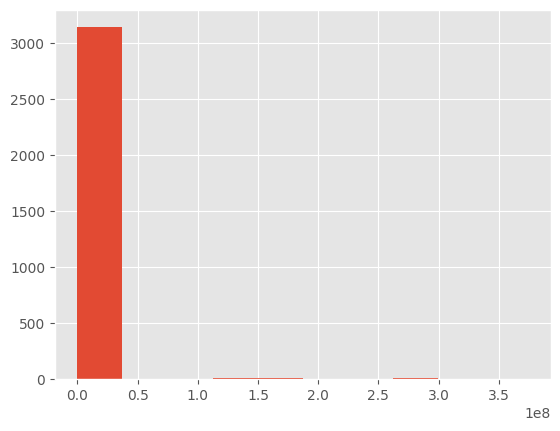

In [13]:
# Vẽ biểu đồ tần suất của Volume
df['volume'].hist(bins=10)

**Phân tích phân bố dữ liệu Volume bằng Histogram**  

🔹 `.hist(bins=10)`  
- Vẽ **biểu đồ histogram** của cột `Volume` với **10 bins (nhóm dữ liệu)**.  
- Giúp trực quan hóa **phân bố dữ liệu**, phát hiện sự **lệch** (skewness) và **giá trị ngoại lai** (outliers).  

**Ý nghĩa của biểu đồ histogram**  

- **Nếu phân bố lệch phải (right-skewed)** → Dữ liệu có nhiều giá trị nhỏ, một số giá trị rất lớn.  
- **Nếu phân bố lệch trái (left-skewed)** → Dữ liệu có nhiều giá trị lớn, một số giá trị rất nhỏ.  
- **Nếu có outliers (điểm nằm xa tập trung chính)** → Có thể cần xử lý như **loại bỏ** hoặc **chuẩn hóa dữ liệu**.  

**Cách xử lý dữ liệu lệch/skewed**  

✅ **Log Transformation** → Dùng `np.log1p(Volume)` để giảm độ lệch.  
✅ **Scaling** → Dùng `MinMaxScaler()` hoặc `StandardScaler()` để chuẩn hóa.  
✅ **Xử lý outliers** → Loại bỏ hoặc thay thế bằng **giá trị trung bình/median**.  


## Train model / Hàm **fit_model_2()**

In [14]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate= lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    for layer in model.layers:
        if isinstance(layer, SimpleRNN):
            layer.reset_states() #Đảm bảo mỗi lần huấn luyện không bị ảnh hưởng bởi trạng thái cũ của LSTM.
    return model, history.history['loss'], history.history['val_loss']

###  Bước 1: Đặt Seed để đảm bảo tính tái lập

Giúp đảm bảo mỗi lần chạy chương trình, các giá trị ngẫu nhiên được tạo ra giống nhau, tránh kết quả huấn luyện thay đổi giữa các lần chạy.

In [15]:
"""
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)
"""

'\nnp.random.seed(1)\ntf.random.set_seed(2)\nrn.seed(3)\n'

### Bước 2: Chuẩn bị dữ liệu huấn luyện (train) và kiểm định (val)

In [16]:
"""
X_train = []
Y_train = []
X_val = []
Y_val = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train, Y_train = np.array(X_train, Y_train)

for i in range(timesteps, val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val, Y_val = np.array(X_val, Y_val)  
"""

'\nX_train = []\nY_train = []\nX_val = []\nY_val = []\n\nfor i in range(timesteps, train.shape[0]):\n    X_train.append(train[i-timesteps:i])\n    Y_train.append(train[i][0])\nX_train, Y_train = np.array(X_train, Y_train)\n\nfor i in range(timesteps, val.shape[0]):\n    X_val.append(val[i-timesteps:i])\n    Y_val.append(val[i][0])\nX_val, Y_val = np.array(X_val, Y_val)  \n'

### Bước 3: Xây dựng mô hình RNN

In [17]:
"""
# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
for i in range(len(hl)-1):
    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))
model.add(SimpleRNN(hl[-1], activation='relu'))
model.add(Dense(1))
"""

"\n# Xây dựng mô hình RNN\nmodel = Sequential()\nmodel.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))\nfor i in range(len(hl)-1):\n    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))\nmodel.add(SimpleRNN(hl[-1], activation='relu'))\nmodel.add(Dense(1))\n"

Thêm một lớp **SimpleRNN đầu tiên**:  
-   `X_train.shape[2]`: Số đặc trưng (features).
-   `input_shape = (X_train.shape[1], X_train.shape[2])`: Định dạng đầu vào (timesteps, số đặc trưng).
-   `activation = 'relu'`: Hàm kích hoạt giúp mô hình học phi tuyến tính.
-   `return_sequences = True`: Giữ lại toàn bộ chuỗi đầu ra để sử dụng trong các lớp tiếp theo.

### Bước 4: Biên dịch mô hình

In [18]:
"""
# Biên dịch
model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')
"""

"\n# Biên dịch\nmodel.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')\n"

### Bước 5: Huấn luyện mô hình

In [19]:
"""
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
"""

'\nhistory = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)\n'

**Cấu hình huấn luyện mô hình**

🔹 Tham số trong quá trình huấn luyện  

✅ `epochs = epochs` → Số vòng huấn luyện  
✅ `batch_size = batch` → Kích thước batch  
✅ `validation_data = (X_val, Y_val)` → Dữ liệu kiểm định để theo dõi hiệu suất sau mỗi epoch  
✅ `verbose = 0` → Không hiển thị log huấn luyện (có thể đặt `verbose = 1` để xem tiến trình)  
✅ `shuffle = False` → Không xáo trộn dữ liệu (do chuỗi thời gian có tính thứ tự)  
✅ `callbacks = callbacks_list` → Danh sách callback hỗ trợ huấn luyện  

### Bước 6: Đảm bảo trạng thái không bị ảnh hưởng khi huấn luyện nhiều lần

In [20]:
"""
for layer in model.layers:
    if isinstance(layer, SimpleRNN):
        layer.reset_states()
"""

'\nfor layer in model.layers:\n    if isinstance(layer, SimpleRNN):\n        layer.reset_states()\n'

### Bước 7: Trả về kết quả

In [21]:
"""
return model, history.history['train_loss'], history.history['val_loss']
"""

"\nreturn model, history.history['train_loss'], history.history['val_loss']\n"

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [22]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [23]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model_2(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

## Hàm **Evaluate_model_2()**

In [24]:
"""
# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100"
    """

'\n# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true))*100"\n    '

In [25]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart (vẽ biểu đồ)

In [26]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [27]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [28]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(4044, 3)


,close,high,low
time,,,
2009-01-05,311.23,311.23,311.23
2009-01-06,314.21,314.21,314.21
2009-01-07,320.53,320.53,320.53
2009-01-08,314.14,314.14,314.14
2009-01-09,312.90,312.90,312.90
...,...,...,...
2025-03-14,1387.03,1394.39,1385.20
2025-03-17,1394.90,1397.28,1389.42
2025-03-18,1388.64,1400.38,1388.64


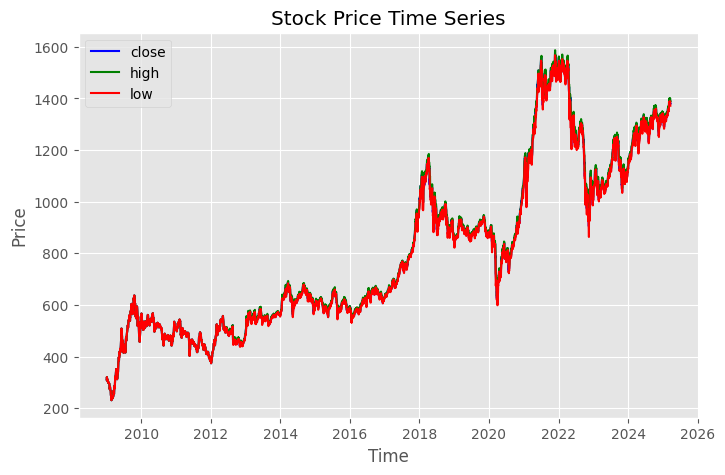

In [29]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [30]:
series.shape

(4044, 3)

In [31]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2832, 3) (606, 3) (606, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [32]:
# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2832, 3) (606, 3) (606, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [33]:
from keras.layers import GRU

In [34]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


2025-06-01 14:04:19.884174: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 1.32578, saving model to best_model11.h5

Epoch 2: val_loss improved from 1.32578 to 1.01687, saving model to best_model11.h5

Epoch 3: val_loss improved from 1.01687 to 0.76183, saving model to best_model11.h5

Epoch 4: val_loss improved from 0.76183 to 0.49359, saving model to best_model11.h5

Epoch 5: val_loss improved from 0.49359 to 0.27626, saving model to best_model11.h5

Epoch 6: val_loss improved from 0.27626 to 0.11895, saving model to best_model11.h5

Epoch 7: val_loss improved from 0.11895 to 0.04777, saving model to best_model11.h5

Epoch 8: val_loss improved from 0.04777 to 0.03019, saving model to best_model11.h5

Epoch 9: val_loss improved from 0.03019 to 0.02762, saving model to best_model11.h5

Epoch 10: val_loss improved from 0.02762 to 0.02616, saving model to best_model11.h5

Epoch 11: val_loss improved from 0.02616 to 0.02415, saving model to best_model11.h5

Epoch 12: val_loss improved from 0.02415 to 0.02090, saving model 

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [35]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00079

Epoch 2: val_loss did not improve from 0.00079

Epoch 3: val_loss did not improve from 0.00079

Epoch 4: val_loss did not improve from 0.00079

Epoch 5: val_loss did not improve from 0.00079

Epoch 6: val_loss did not improve from 0.00079

Epoch 7: val_loss did not improve from 0.00079

Epoch 8: val_loss did not improve from 0.00079

Epoch 9: val_loss did not improve from 0.00079

Epoch 10: val_loss did not improve from 0.00079

Epoch 11: val_loss did not improve from 0.00079

Epoch 12: val_loss did not improve from 0.00079

Epoch 13: val_loss did not improve from 0.00079

Epoch 14: val_loss did not improve from 0.00079

Epoch 15: val_loss did not improve from 0.00079

Epoch 16: val_loss did not improve from 0.00079

Epoch 17: val_loss did not improve from 0.00079

Epoch 18: val_loss did not improve from 0.00079

Epoch 19: val_loss did not improve from 0.00079

Epoch 20: val_loss did not improve from 0.00079

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

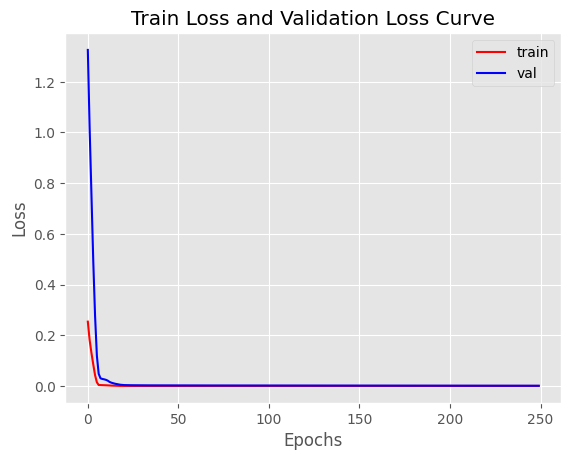

In [36]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [37]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [38]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0002548671855650555
RMSE = 0.015964560299771977
MAPE = 0.012352491620391736
R-Squared Score = 0.9803574524457459


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

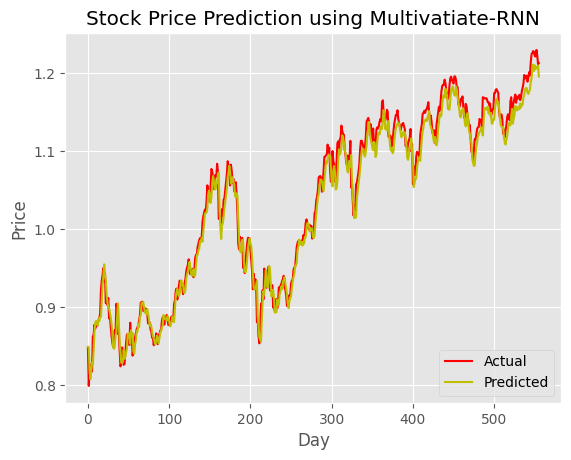

In [39]:
plot_data_2(true, predicted)

In [40]:
# Save a model
model.save('3VAR-VN30index-rnn.keras')

In [41]:
del model

# Model 2: Multivariate-3-GRU

## GRU

### Import các thư viện cần thiết

In [42]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [43]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras import optimizers

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [46]:
plt.style.use('ggplot')

### Hàm callback

In [47]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var-Vn30-gru.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"VN30 Index.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [49]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,open,high,low,close,volume
time,,,,,
2009-01-05,311.23,311.23,311.23,311.23,NaN
2009-01-06,314.21,314.21,314.21,314.21,NaN
2009-01-07,320.53,320.53,320.53,320.53,NaN
2009-01-08,314.14,314.14,314.14,314.14,NaN
2009-01-09,312.90,312.90,312.90,312.90,NaN


In [50]:
df.isnull().sum()

open        0
high        0
low         0
close       0
volume    859
dtype: int64

### Tiền xử lí dữ liệu

In [51]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [52]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999562
high      0.999783
low       0.999789
close     1.000000
volume    0.169492
Name: close, dtype: float64

In [53]:
print(df.describe().volume) 

count    3.185000e+03
mean     3.279171e+06
std      2.776577e+07
min      4.540000e+03
25%      3.809000e+04
50%      6.036000e+04
75%      1.560100e+05
max      3.744900e+08
Name: volume, dtype: float64


<Axes: >

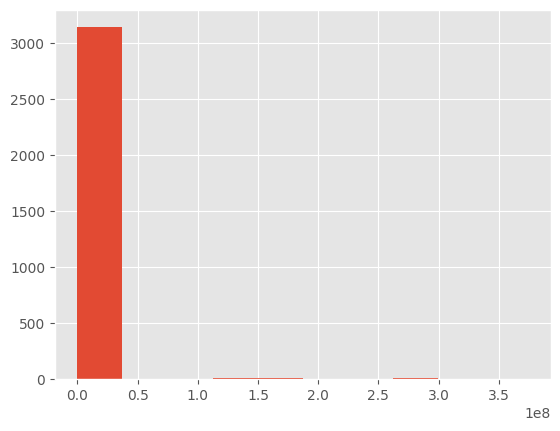

In [54]:
df['volume'].hist(bins= 10)

## Train model / Hàm **fit_model_3()**

In [55]:
def fit_model_3(train, val, timesteps, hl, lr, batch, epochs):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)
    """
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Thêm các lớp vào mô hình
    model = Sequential()
    model.add(GRU(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i], activation='relu', return_sequences= True))
    model.add(GRU(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện dữ liệu
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)
    
    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, GRU):
            layer.reset_states()
    
    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_3()**

In [56]:
def evaluate_model_3(model, test, timesteps):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    """
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)

    # Các chỉ số đánh giá
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat


## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [57]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-4, 1e-3],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [58]:
# Hàm grid search
def grid_search_rnn(train, val, test, param_grid):
    results = []
    best_score = float('inf')
    best_params = None

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*(param_grid.values())))
    param_names = param_grid.keys()

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f'Training with params: {params}')

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

        # Trả về kết quả
        results_df = pd.DataFrame(results)
        return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [59]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [60]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [61]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(4044, 3)


,close,high,low
time,,,
2009-01-05,311.23,311.23,311.23
2009-01-06,314.21,314.21,314.21
2009-01-07,320.53,320.53,320.53
2009-01-08,314.14,314.14,314.14
2009-01-09,312.90,312.90,312.90
...,...,...,...
2025-03-14,1387.03,1394.39,1385.20
2025-03-17,1394.90,1397.28,1389.42
2025-03-18,1388.64,1400.38,1388.64


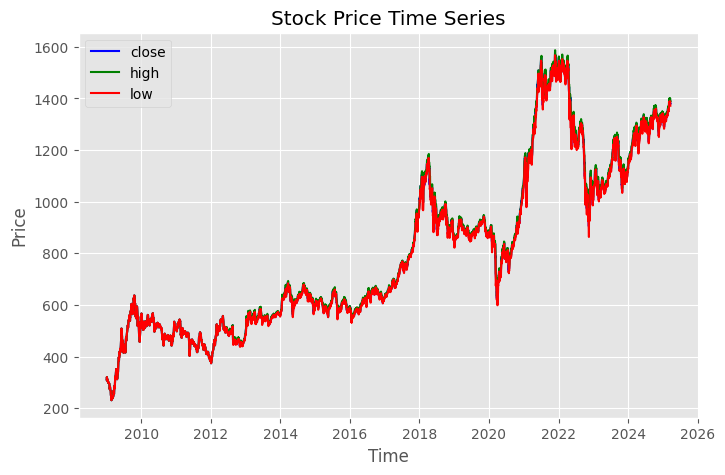

In [62]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [63]:
series.shape

(4044, 3)

In [64]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2832, 3) (606, 3) (606, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [65]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2832, 3) (606, 3) (606, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [66]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 1.18807, saving model to 3Var-Vn30-gru.h5

Epoch 2: val_loss improved from 1.18807 to 0.86750, saving model to 3Var-Vn30-gru.h5

Epoch 3: val_loss improved from 0.86750 to 0.47045, saving model to 3Var-Vn30-gru.h5

Epoch 4: val_loss improved from 0.47045 to 0.19656, saving model to 3Var-Vn30-gru.h5

Epoch 5: val_loss improved from 0.19656 to 0.08343, saving model to 3Var-Vn30-gru.h5

Epoch 6: val_loss improved from 0.08343 to 0.05183, saving model to 3Var-Vn30-gru.h5

Epoch 7: val_loss improved from 0.05183 to 0.03951, saving model to 3Var-Vn30-gru.h5

Epoch 8: val_loss improved from 0.03951 to 0.03109, saving model to 3Var-Vn30-gru.h5

Epoch 9: val_loss improved from 0.03109 to 0.02326, saving model to 3Var-Vn30-gru.h5

Epoch 10: val_loss improved from 0.02326 to 0.01488, saving model to 3Var-Vn30-gru.h5

Epoch 11: val_loss improved from 0.01488 to 0.00915, saving model to 3Var-Vn30-gru.h5

Epoch 12: val_loss improved from 0.00915 to 0.00589, sa

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [67]:
timesteps = 30
hl = [40, 35]
lr = 1e-4
batch_size = 32
num_epochs = 200

model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00112

Epoch 2: val_loss did not improve from 0.00112

Epoch 3: val_loss did not improve from 0.00112

Epoch 4: val_loss did not improve from 0.00112

Epoch 5: val_loss did not improve from 0.00112

Epoch 6: val_loss did not improve from 0.00112

Epoch 7: val_loss did not improve from 0.00112

Epoch 8: val_loss did not improve from 0.00112

Epoch 9: val_loss did not improve from 0.00112

Epoch 10: val_loss did not improve from 0.00112

Epoch 11: val_loss did not improve from 0.00112

Epoch 12: val_loss did not improve from 0.00112

Epoch 13: val_loss did not improve from 0.00112

Epoch 14: val_loss did not improve from 0.00112

Epoch 15: val_loss did not improve from 0.00112

Epoch 16: val_loss did not improve from 0.00112

Epoch 17: val_loss did not improve from 0.00112

Epoch 18: val_loss did not improve from 0.00112

Epoch 19: val_loss did not improve from 0.00112

Epoch 20: val_loss did not improve from 0.00112

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

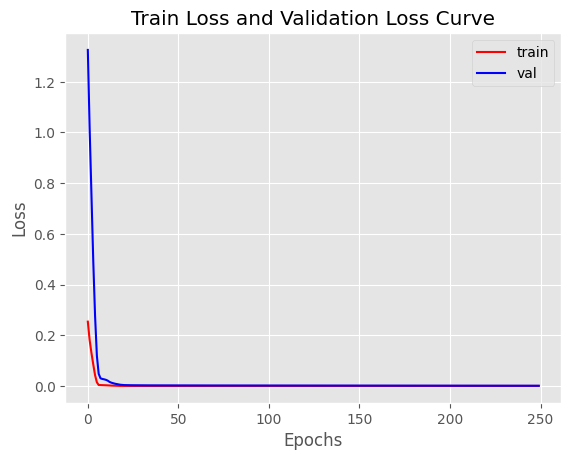

In [68]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [69]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [70]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0002739016141088817
RMSE = 0.016549973235896236
MAPE = 0.012732693692764457
R-Squared Score = 0.9797689542543845


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

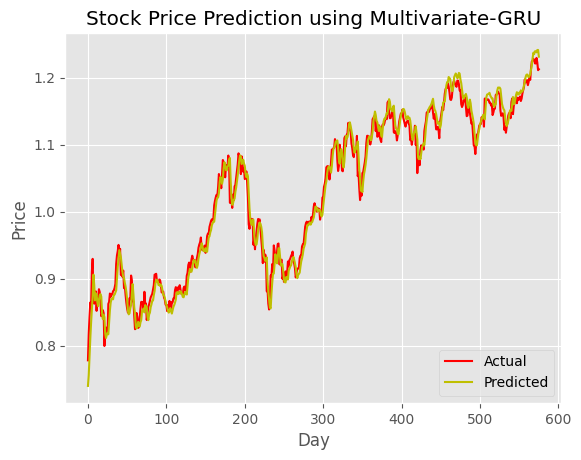

In [71]:
plot_data_3(true, predicted)

In [72]:
# Save a model
model.save('3VAR-VN30index-gru.keras')

In [73]:
del model

# Model 3: Multivariate-3-LSTM

## LSTM

### Import các thư viện cần thiết

In [3]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

2025-06-02 16:07:42.774729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748880462.974525      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748880463.036873      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

In [7]:
plt.style.use('ggplot')

### Hàm callback

In [8]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var_vn30_lstm.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"VN30 Index.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [10]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,open,high,low,close,volume
time,,,,,
2009-01-05,311.23,311.23,311.23,311.23,NaN
2009-01-06,314.21,314.21,314.21,314.21,NaN
2009-01-07,320.53,320.53,320.53,320.53,NaN
2009-01-08,314.14,314.14,314.14,314.14,NaN
2009-01-09,312.90,312.90,312.90,312.90,NaN


In [11]:
df.isnull().sum()

open        0
high        0
low         0
close       0
volume    859
dtype: int64

### Tiền xử lí dữ liệu

In [12]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [13]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999562
high      0.999783
low       0.999789
close     1.000000
volume    0.169492
Name: close, dtype: float64

count    3.185000e+03
mean     3.279171e+06
std      2.776577e+07
min      4.540000e+03
25%      3.809000e+04
50%      6.036000e+04
75%      1.560100e+05
max      3.744900e+08
Name: volume, dtype: float64


<Axes: >

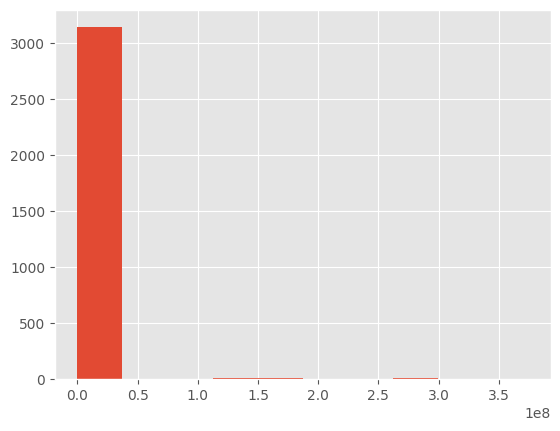

In [14]:
print(df.describe().volume) 
df['volume'].hist(bins= 10)

## Train model / Hàm **fit_model_4()**

In [15]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation='relu', return_sequences= True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, batch_size= batch, epochs= epochs, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)

    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_state()

    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_4()**

In [16]:
def evaluate_model_4(model, test, timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Các chỉ số
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [17]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [18]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [19]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [20]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [21]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(4044, 3)


,close,high,low
time,,,
2009-01-05,311.23,311.23,311.23
2009-01-06,314.21,314.21,314.21
2009-01-07,320.53,320.53,320.53
2009-01-08,314.14,314.14,314.14
2009-01-09,312.90,312.90,312.90
...,...,...,...
2025-03-14,1387.03,1394.39,1385.20
2025-03-17,1394.90,1397.28,1389.42
2025-03-18,1388.64,1400.38,1388.64


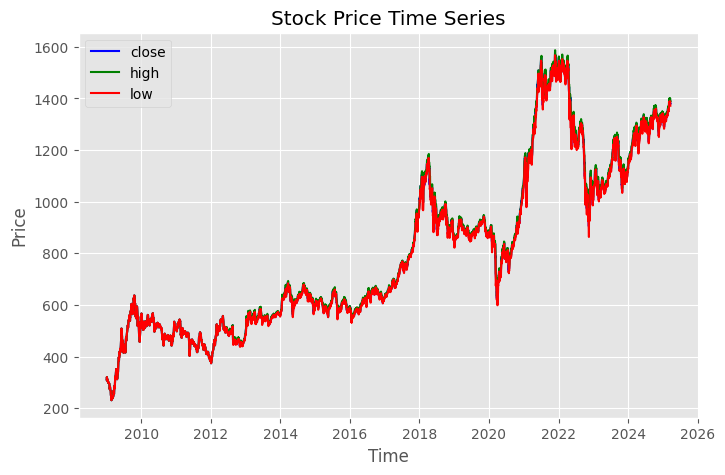

In [22]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [23]:
series.shape

(4044, 3)

In [24]:

n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)


(2832, 3) (606, 3) (606, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [25]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2832, 3) (606, 3) (606, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [97]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00880, saving model to 3Var_vn30_lstm.h5

Epoch 2: val_loss improved from 0.00880 to 0.00833, saving model to 3Var_vn30_lstm.h5

Epoch 3: val_loss did not improve from 0.00833

Epoch 4: val_loss did not improve from 0.00833

Epoch 5: val_loss did not improve from 0.00833

Epoch 6: val_loss did not improve from 0.00833

Epoch 7: val_loss did not improve from 0.00833

Epoch 8: val_loss did not improve from 0.00833

Epoch 9: val_loss did not improve from 0.00833

Epoch 10: val_loss did not improve from 0.00833

Epoch 11: val_loss did not improve from 0.00833

Epoch 12: val_loss did not improve from 0.00833

Epoch 13: val_loss did not improve from 0.00833

Epoch 14: val_loss did not improve from 0.00833

Epoch 15: val_loss did not improve from 0.00833

Epoch 16: val_loss did not improve from 0.00833

Epoch 17: val_loss did not improve from 0.00833

Epoch 18: val_loss did not improve from 0.00833

Epoch 19: val_loss did not improve from 0.00833

Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00126

Epoch 2: val_loss did not improve from 0.00126

Epoch 3: val_loss did not improve from 0.00126

Epoch 4: val_loss did not improve from 0.00126

Epoch 5: val_loss did not improve from 0.00126

Epoch 6: val_loss did not improve from 0.00126

Epoch 7: val_loss did not improve from 0.00126

Epoch 8: val_loss did not improve from 0.00126

Epoch 9: val_loss did not improve from 0.00126

Epoch 10: val_loss did not improve from 0.00126

Epoch 11: val_loss did not improve from 0.00126

Epoch 12: val_loss did not improve from 0.00126

Epoch 13: val_loss did not improve from 0.00126

Epoch 14: val_loss did not improve from 0.00126

Epoch 15: val_loss did not improve from 0.00126

Epoch 16: val_loss did not improve from 0.00126

Epoch 17: val_loss did not improve from 0.00126

Epoch 18: val_loss did not improve from 0.00126

Epoch 19: val_loss did not improve from 0.00126

Epoch 20: val_loss did not improve from 0.00126

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00083

Epoch 2: val_loss did not improve from 0.00083

Epoch 3: val_loss did not improve from 0.00083

Epoch 4: val_loss did not improve from 0.00083

Epoch 5: val_loss did not improve from 0.00083

Epoch 6: val_loss did not improve from 0.00083

Epoch 7: val_loss did not improve from 0.00083

Epoch 8: val_loss did not improve from 0.00083

Epoch 9: val_loss did not improve from 0.00083

Epoch 10: val_loss did not improve from 0.00083

Epoch 11: val_loss did not improve from 0.00083

Epoch 12: val_loss did not improve from 0.00083

Epoch 13: val_loss did not improve from 0.00083

Epoch 14: val_loss did not improve from 0.00083

Epoch 15: val_loss did not improve from 0.00083

Epoch 16: val_loss did not improve from 0.00083

Epoch 17: val_loss did not improve from 0.00083

Epoch 18: val_loss did not improve from 0.00083

Epoch 19: val_loss did not improve from 0.00083

Epoch 20: val_loss did not improve from 0.00083

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00083

Epoch 2: val_loss did not improve from 0.00083

Epoch 3: val_loss did not improve from 0.00083

Epoch 4: val_loss did not improve from 0.00083

Epoch 5: val_loss did not improve from 0.00083

Epoch 6: val_loss did not improve from 0.00083

Epoch 7: val_loss did not improve from 0.00083

Epoch 8: val_loss did not improve from 0.00083

Epoch 9: val_loss did not improve from 0.00083

Epoch 10: val_loss did not improve from 0.00083

Epoch 11: val_loss did not improve from 0.00083

Epoch 12: val_loss did not improve from 0.00083

Epoch 13: val_loss did not improve from 0.00083

Epoch 14: val_loss did not improve from 0.00083

Epoch 15: val_loss did not improve from 0.00083

Epoch 16: val_loss did not improve from 0.00083

Epoch 17: val_loss did not improve from 0.00083

Epoch 18: val_loss did not improve from 0.00083

Epoch 19: val_loss did not improve from 0.00083

Epoch 20: val_loss did not improve from 0.00083

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00076

Epoch 2: val_loss did not improve from 0.00076

Epoch 3: val_loss did not improve from 0.00076

Epoch 4: val_loss did not improve from 0.00076

Epoch 5: val_loss did not improve from 0.00076

Epoch 6: val_loss did not improve from 0.00076

Epoch 7: val_loss did not improve from 0.00076

Epoch 8: val_loss did not improve from 0.00076

Epoch 9: val_loss did not improve from 0.00076

Epoch 10: val_loss did not improve from 0.00076

Epoch 11: val_loss did not improve from 0.00076

Epoch 12: val_loss did not improve from 0.00076

Epoch 13: val_loss did not improve from 0.00076

Epoch 14: val_loss did not improve from 0.00076

Epoch 15: val_loss did not improve from 0.00076

Epoch 16: val_loss did not improve from 0.00076

Epoch 17: val_loss did not improve from 0.00076

Epoch 18: val_loss did not improve from 0.00076

Epoch 19: val_loss did not improve from 0.00076

Epoch 20: val_loss did not improve from 0.00076

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00076

Epoch 2: val_loss did not improve from 0.00076

Epoch 3: val_loss did not improve from 0.00076

Epoch 4: val_loss did not improve from 0.00076

Epoch 5: val_loss did not improve from 0.00076

Epoch 6: val_loss did not improve from 0.00076

Epoch 7: val_loss did not improve from 0.00076

Epoch 8: val_loss did not improve from 0.00076

Epoch 9: val_loss did not improve from 0.00076

Epoch 10: val_loss did not improve from 0.00076

Epoch 11: val_loss did not improve from 0.00076

Epoch 12: val_loss did not improve from 0.00076

Epoch 13: val_loss did not improve from 0.00076

Epoch 14: val_loss did not improve from 0.00076

Epoch 15: val_loss did not improve from 0.00076

Epoch 16: val_loss did not improve from 0.00076

Epoch 17: val_loss did not improve from 0.00076

Epoch 18: val_loss did not improve from 0.00076

Epoch 19: val_loss did not improve from 0.00076

Epoch 20: val_loss did not improve from 0.00076

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00076

Epoch 2: val_loss did not improve from 0.00076

Epoch 3: val_loss did not improve from 0.00076

Epoch 4: val_loss did not improve from 0.00076

Epoch 5: val_loss did not improve from 0.00076

Epoch 6: val_loss did not improve from 0.00076

Epoch 7: val_loss did not improve from 0.00076

Epoch 8: val_loss did not improve from 0.00076

Epoch 9: val_loss did not improve from 0.00076

Epoch 10: val_loss did not improve from 0.00076

Epoch 11: val_loss did not improve from 0.00076

Epoch 12: val_loss did not improve from 0.00076

Epoch 13: val_loss did not improve from 0.00076

Epoch 14: val_loss did not improve from 0.00076

Epoch 15: val_loss did not improve from 0.00076

Epoch 16: val_loss did not improve from 0.00076

Epoch 17: val_loss did not improve from 0.00076

Epoch 18: val_loss did not improve from 0.00076

Epoch 19: val_loss did not improve from 0.00076

Epoch 20: val_loss did not improve from 0.00076

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00076

Epoch 2: val_loss did not improve from 0.00076

Epoch 3: val_loss did not improve from 0.00076

Epoch 4: val_loss did not improve from 0.00076

Epoch 5: val_loss did not improve from 0.00076

Epoch 6: val_loss did not improve from 0.00076

Epoch 7: val_loss did not improve from 0.00076

Epoch 8: val_loss did not improve from 0.00076

Epoch 9: val_loss did not improve from 0.00076

Epoch 10: val_loss did not improve from 0.00076

Epoch 11: val_loss did not improve from 0.00076

Epoch 12: val_loss did not improve from 0.00076

Epoch 13: val_loss did not improve from 0.00076

Epoch 14: val_loss did not improve from 0.00076

Epoch 15: val_loss did not improve from 0.00076

Epoch 16: val_loss did not improve from 0.00076

Epoch 17: val_loss did not improve from 0.00076

Epoch 18: val_loss did not improve from 0.00076

Epoch 19: val_loss did not improve from 0.00076

Epoch 20: val_loss did not improve from 0.00076

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00076

Epoch 2: val_loss did not improve from 0.00076

Epoch 3: val_loss did not improve from 0.00076

Epoch 4: val_loss did not improve from 0.00076

Epoch 5: val_loss did not improve from 0.00076

Epoch 6: val_loss did not improve from 0.00076

Epoch 7: val_loss did not improve from 0.00076

Epoch 8: val_loss did not improve from 0.00076

Epoch 9: val_loss did not improve from 0.00076

Epoch 10: val_loss did not improve from 0.00076

Epoch 11: val_loss did not improve from 0.00076

Epoch 12: val_loss did not improve from 0.00076

Epoch 13: val_loss did not improve from 0.00076

Epoch 14: val_loss did not improve from 0.00076

Epoch 15: val_loss did not improve from 0.00076

Epoch 16: val_loss did not improve from 0.00076

Epoch 17: val_loss did not improve from 0.00076

Epoch 18: val_loss did not improve from 0.00076

Epoch 19: val_loss did not improve from 0.00076

Epoch 20: val_loss did not improve from 0.00076

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00076

Epoch 2: val_loss did not improve from 0.00076

Epoch 3: val_loss did not improve from 0.00076

Epoch 4: val_loss did not improve from 0.00076

Epoch 5: val_loss did not improve from 0.00076

Epoch 6: val_loss did not improve from 0.00076

Epoch 7: val_loss did not improve from 0.00076

Epoch 8: val_loss did not improve from 0.00076

Epoch 9: val_loss did not improve from 0.00076

Epoch 10: val_loss did not improve from 0.00076

Epoch 11: val_loss did not improve from 0.00076

Epoch 12: val_loss did not improve from 0.00076

Epoch 13: val_loss did not improve from 0.00076

Epoch 14: val_loss did not improve from 0.00076

Epoch 15: val_loss did not improve from 0.00076

Epoch 16: val_loss did not improve from 0.00076

Epoch 17: val_loss did not improve from 0.00076

Epoch 18: val_loss did not improve from 0.00076

Epoch 19: val_loss did not improve from 0.00076

Epoch 20: val_loss did not improve from 0.00076

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00076

Epoch 2: val_loss did not improve from 0.00076

Epoch 3: val_loss did not improve from 0.00076

Epoch 4: val_loss did not improve from 0.00076

Epoch 5: val_loss did not improve from 0.00076

Epoch 6: val_loss did not improve from 0.00076

Epoch 7: val_loss did not improve from 0.00076

Epoch 8: val_loss did not improve from 0.00076

Epoch 9: val_loss did not improve from 0.00076

Epoch 10: val_loss did not improve from 0.00076

Epoch 11: val_loss did not improve from 0.00076

Epoch 12: val_loss did not improve from 0.00076

Epoch 13: val_loss did not improve from 0.00076

Epoch 14: val_loss did not improve from 0.00076

Epoch 15: val_loss did not improve from 0.00076

Epoch 16: val_loss did not improve from 0.00076

Epoch 17: val_loss did not improve from 0.00076

Epoch 18: val_loss did not improve from 0.00076

Epoch 19: val_loss did not improve from 0.00076

Epoch 20: val_loss did not improve from 0.00076

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00074

Epoch 2: val_loss did not improve from 0.00074

Epoch 3: val_loss did not improve from 0.00074

Epoch 4: val_loss did not improve from 0.00074

Epoch 5: val_loss did not improve from 0.00074

Epoch 6: val_loss did not improve from 0.00074

Epoch 7: val_loss did not improve from 0.00074

Epoch 8: val_loss did not improve from 0.00074

Epoch 9: val_loss did not improve from 0.00074

Epoch 10: val_loss did not improve from 0.00074

Epoch 11: val_loss did not improve from 0.00074

Epoch 12: val_loss did not improve from 0.00074

Epoch 13: val_loss did not improve from 0.00074

Epoch 14: val_loss did not improve from 0.00074

Epoch 15: val_loss did not improve from 0.00074

Epoch 16: val_loss did not improve from 0.00074

Epoch 17: val_loss did not improve from 0.00074

Epoch 18: val_loss did not improve from 0.00074

Epoch 19: val_loss did not improve from 0.00074

Epoch 20: val_loss did not improve from 0.00074

Epoch 21: val_loss did not i

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [60]:
timesteps = 30
hl = [40, 35]
lr = 1e-3
batch_size = 32
num_epochs = 250

model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00044

Epoch 2: val_loss did not improve from 0.00044

Epoch 3: val_loss did not improve from 0.00044

Epoch 4: val_loss did not improve from 0.00044

Epoch 5: val_loss did not improve from 0.00044

Epoch 6: val_loss did not improve from 0.00044

Epoch 7: val_loss did not improve from 0.00044

Epoch 8: val_loss did not improve from 0.00044

Epoch 9: val_loss did not improve from 0.00044

Epoch 10: val_loss did not improve from 0.00044

Epoch 11: val_loss did not improve from 0.00044

Epoch 12: val_loss did not improve from 0.00044

Epoch 13: val_loss did not improve from 0.00044

Epoch 14: val_loss did not improve from 0.00044

Epoch 15: val_loss did not improve from 0.00044

Epoch 16: val_loss did not improve from 0.00044

Epoch 17: val_loss did not improve from 0.00044

Epoch 18: val_loss did not improve from 0.00044

Epoch 19: val_loss did not improve from 0.00044

Epoch 20: val_loss did not improve from 0.00044

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

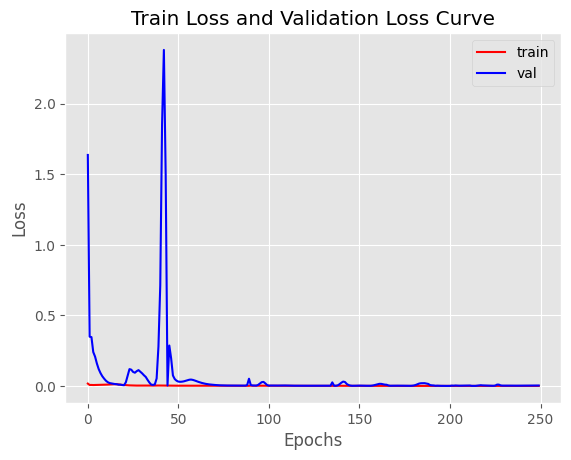

In [61]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [62]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [63]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0012526778868956426
RMSE = 0.03539318983781545
MAPE = 0.02665122978493778
R-Squared Score = 0.907474135496579


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

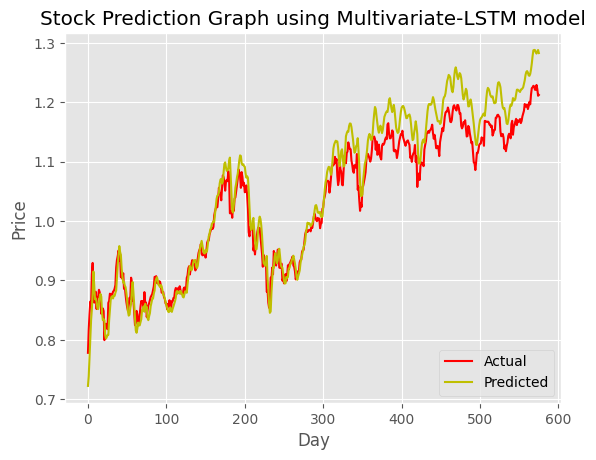

In [64]:
plot_data_4(true, predicted)

In [103]:
# Save a model
model.save('3VAR-VN30index-lstm.keras')

In [104]:
del model